In [12]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
import networkx as nx

In [7]:
import matplotlib.pyplot as plt

In [8]:
import psycopg2

In [9]:
import pandas as pd

In [10]:
DB_NAME = 'mapData'
DB_USER = 'postgres'
DB_PASSWORD = '1234'
DB_HOST = 'localhost'

In [11]:
# Establish a connection to the database
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST)

In [12]:
# Create a cursor object to execute SQL queries
cur = conn.cursor()

In [13]:
# Fetch data from table
cur.execute('SELECT * FROM edges_lrt_mrt')
rows = cur.fetchall()

In [14]:
# Convert the fetched data into a pandas DataFrame for easier manipulation
columns = ['id','source_station_id', 'destination_station_id', 'distance']
df = pd.DataFrame(rows, columns=columns)

In [15]:
cur.close()
conn.close()

In [16]:
# Display the fetched data
print(df)

      id  source_station_id  destination_station_id  distance
0    309                  1                       2         3
1    310                  2                       3         2
2    311                  3                       4         3
3    312                  4                       5         3
4    313                  5                       6         3
..   ...                ...                     ...       ...
179  488                 84                      47         1
180  489                  5                     160        10
181  490                  9                     155         2
182  491                155                      27         2
183  492                  9                      27         0

[184 rows x 4 columns]


In [17]:
import networkx as nx

In [18]:
# Create an empty graph
G = nx.Graph()

In [19]:
# Add edges representing connections between stations
for index, row in df.iterrows():
    G.add_edge(row['source_station_id'], row['destination_station_id'], weight=row['distance'])


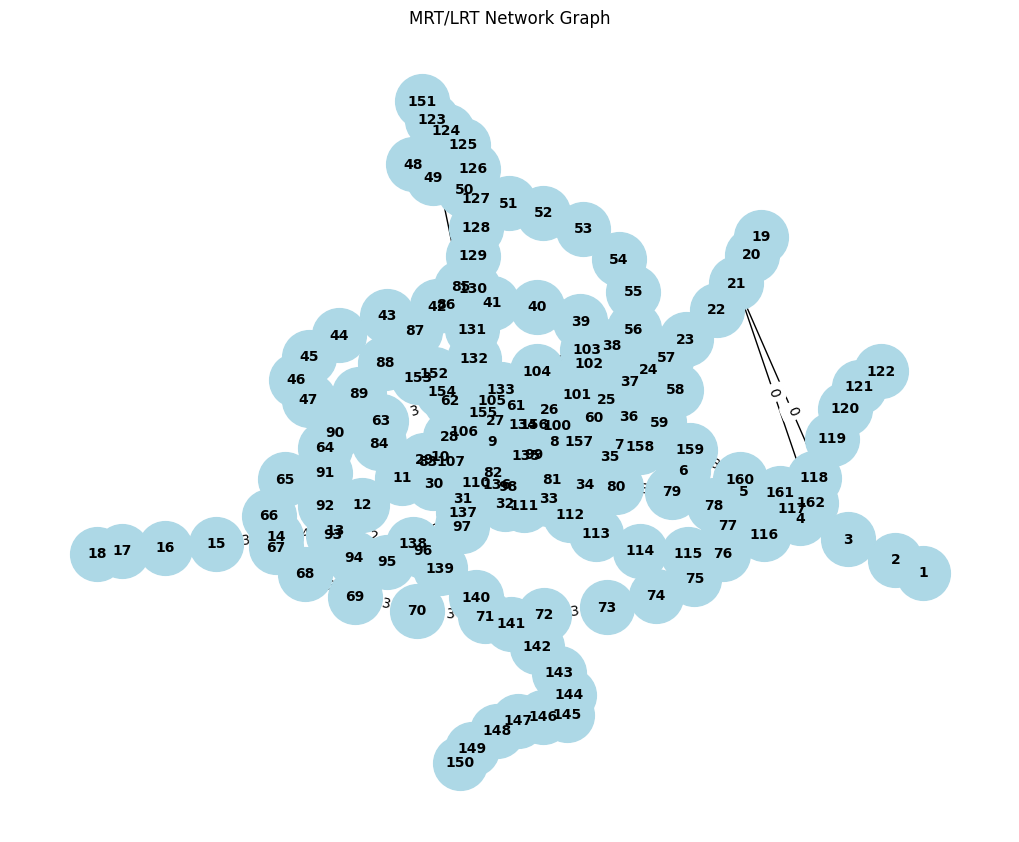

In [20]:
# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('MRT/LRT Network Graph')
plt.show()

In [23]:
import heapq
def astar_shortest_path(graph, start_station_id, end_station_id):
    # Calculate the heuristic distance between two stations
    def heuristic_distance(station1, station2):
        """ def heuristic_distance(station1, station2):
            x1, y1 = station1
            x2, y2 = station2
            distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            return distance """
        return 0
    
    # Define the priority queue for the open set
    open_set = [(0, start_station_id)]
    # Define the set of visited stations
    visited = set()
    # Define the dictionary to store the actual distance from the start station to each station
    g_score = {start_station_id: 0}
    # Define the dictionary to store the estimated total distance from the start station to each station
    f_score = {start_station_id: heuristic_distance(start_station_id, end_station_id)}
    # Define the dictionary to store the previous station in the shortest path
    came_from = {}
    
    while open_set:
        # Get the station with the lowest f_score
        _, current_station = heapq.heappop(open_set)
        
        if current_station == end_station_id:
            # Reconstruct the path from the end station to the start station
            path = [current_station]
            while current_station != start_station_id:
                current_station = came_from[current_station]
                path.append(current_station)
            path.reverse()
            return path
        
        # Add the current station to the visited set
        visited.add(current_station)
        
        
        # Explore the neighbors of the current station
        for neighbor in graph.neighbors(current_station):
            if neighbor in visited:
                continue
            
            # Calculate the tentative g_score for the neighbor
            tentative_g_score = g_score[current_station] + graph[current_station][neighbor]['weight']
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                # Update the g_score and f_score for the neighbor
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic_distance(neighbor, end_station_id)
                # Update the came_from dictionary
                came_from[neighbor] = current_station
                # Add the neighbor to the open set
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    # If no path is found, return None
    return None


In [25]:
# Test the A* algorithm
start_station_id = 60
end_station_id = 128
path = astar_shortest_path(G, start_station_id, end_station_id)
print("Shortest path:", path)


Shortest path: [60, 61, 133, 132, 131, 130, 129, 128]
